In [75]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [12]:
os.getcwd()
os.chdir("/tf")

## Step 5

### Step 5 - Highlight 2
- The performance of Bi-directional LSTM on real-world data.

In [13]:
data = pd.read_csv("./models/data/train.csv", usecols=list(range(1, 8)))
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
col_names = data.columns[1:]
target_combinations = pd.DataFrame(np.unique(data.iloc[:, 1:], axis=0), columns=col_names)
target_combinations['target_class'] = np.arange(target_combinations.shape[0])

In [16]:
train_df, valid_df = train_test_split(data, train_size=0.9, random_state=1234)
valid_df, test_df = train_test_split(valid_df, train_size=0.5, random_state=1234)

In [17]:
model = keras.models.load_model("./models/data/bidirectional.keras")

In [35]:
batch_size = 32
max_tokens = 10_000
max_length = 900

y_train = train_df.iloc[:, 1:]
y_valid = valid_df.iloc[:, 1:]
y_test = test_df.iloc[:, 1:]

x_train = train_df.comment_text.to_numpy()
x_valid = valid_df.comment_text.to_numpy()
x_test = test_df.comment_text.to_numpy()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [36]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = valid_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [41]:
bidir_pred = np.where(model.predict(int_test_ds) >= 0.5, 1, 0)

In [47]:
bidir_pred = pd.DataFrame(bidir_pred, columns=col_names)

In [51]:
bidir_pred = pd.merge(bidir_pred, target_combinations, on=list(col_names))

In [53]:
y_test = pd.merge(y_test, target_combinations, on=list(col_names))

In [57]:
bidir_pred = bidir_pred.iloc[:, -1]
y_test = y_test.iloc[:, -1]

In [60]:
accuracy_score(y_test, bidir_pred)

0.9525003133224715

In [62]:
precision_score(y_test, bidir_pred, average='weighted')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9374633613299285

In [63]:
recall_score(y_test, bidir_pred, average='weighted')

0.9525003133224715

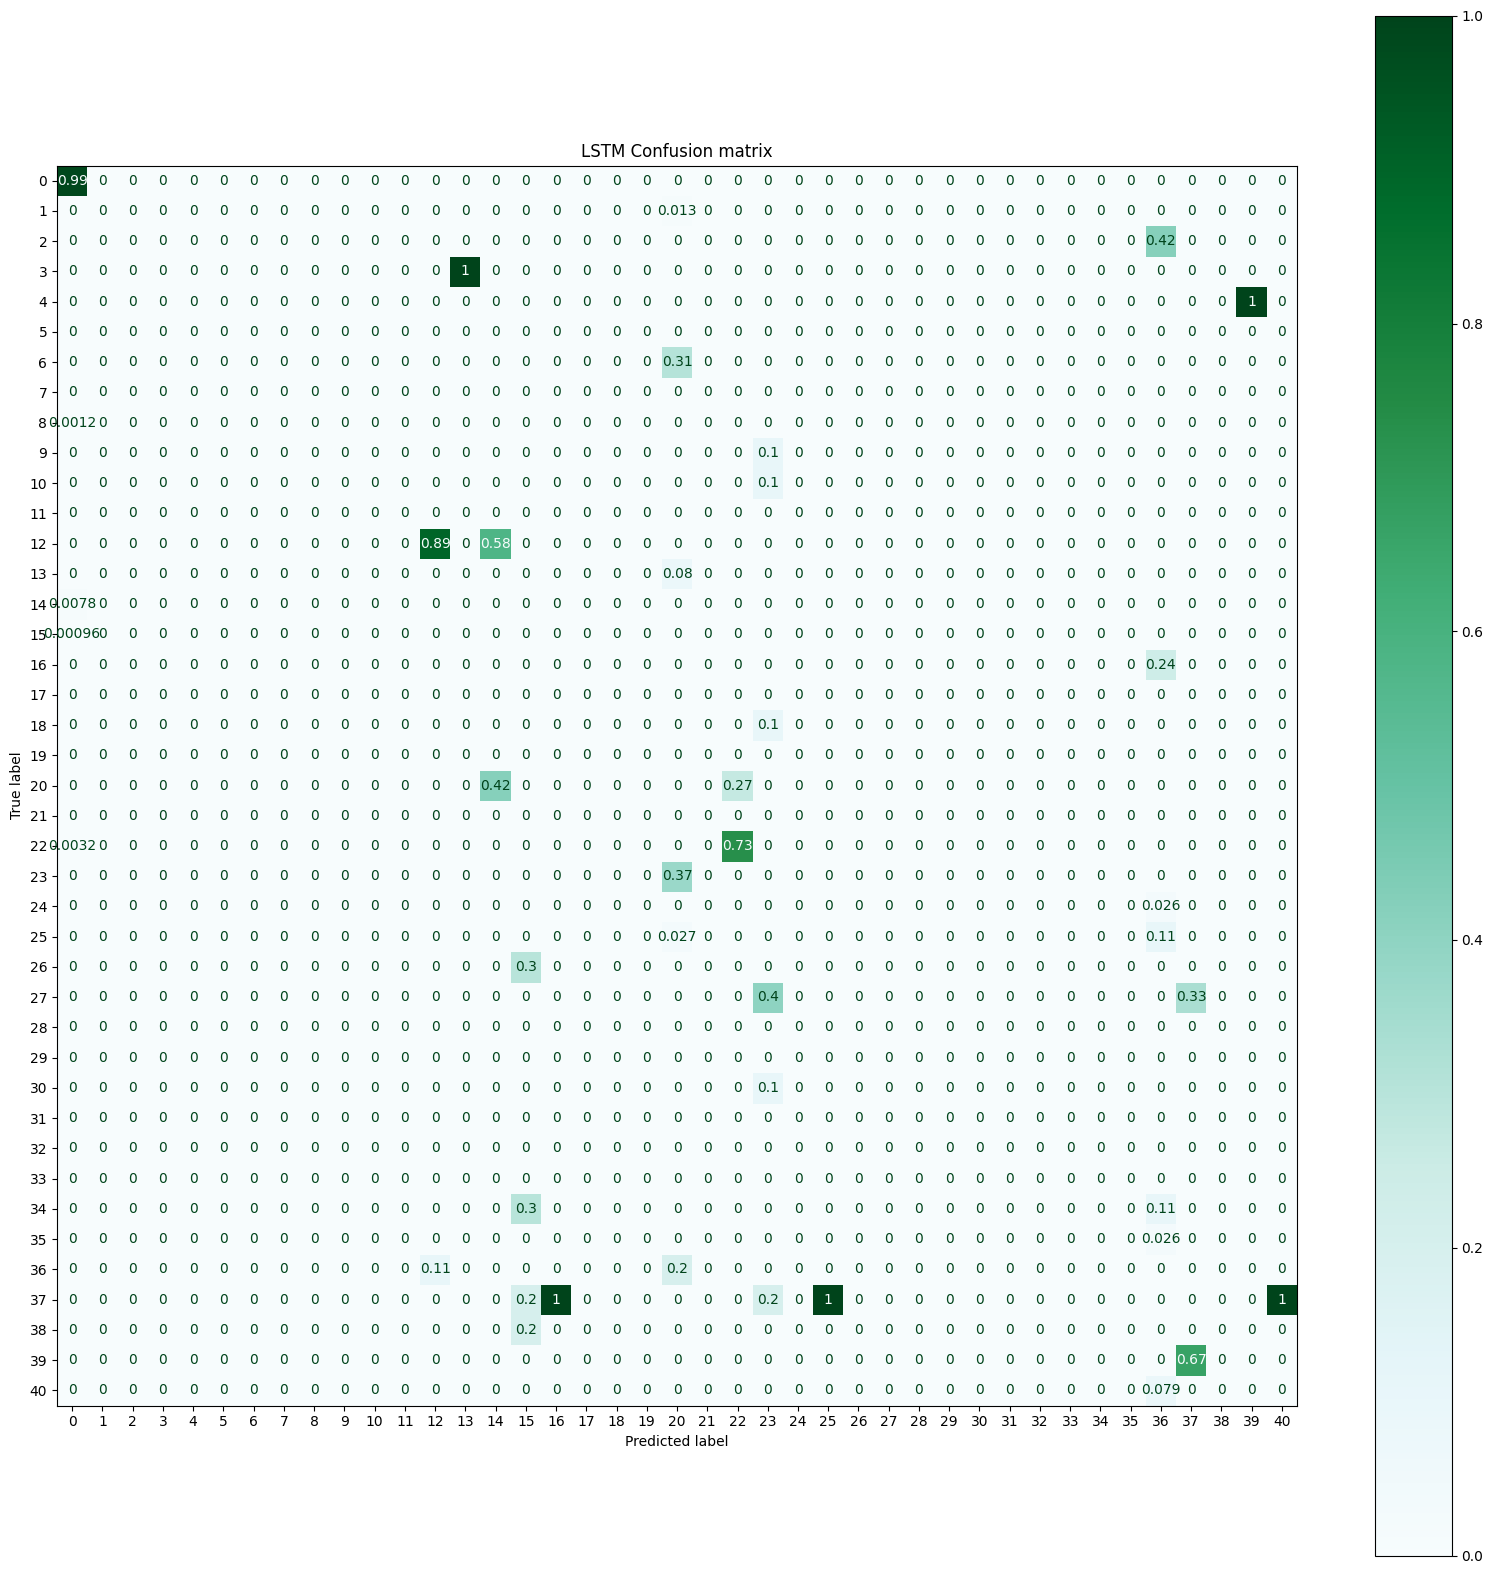

In [82]:
conf_matrix = confusion_matrix(y_test, bidir_pred, labels=range(41), normalize='pred')
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(41))
fig, ax = plt.subplots(figsize=(20, 20))
plt.title("LSTM Confusion matrix")
disp.plot(ax=ax, cmap='BuGn')
plt.savefig("lstm_conf_m.jpg")
plt.show()

In [83]:
target_combinations.iloc[[12, 22, 36]]

,toxic,severe_toxic,obscene,threat,insult,identity_hate,target_class
12,1,0,0,0,0,0,12
22,1,0,1,0,1,0,22
36,1,1,1,0,1,0,36


In [84]:
!pip freeze > requirements.txt